In [18]:
import torch
from torchcfm.optimal_transport import OTPlanSampler
import time
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
def calc_next_point(points, angles):
    alpha = angles
    # beta = torch.maximum(torch.pi / 2 - torch.abs(alpha), torch.tensor(0))
    beta = torch.pi / 2 - torch.abs(alpha)
    x = torch.sin(beta) + points[:, 0]
    y_m = alpha / torch.abs(alpha) * torch.cos(beta) + points[:, 1]
    next_point = torch.vstack((x, y_m)).T
    return next_point


def calc_arm_pos(angles):
    first_point = calc_next_point(torch.tensor([[0, 0]]), angles[:, 0])
    middle_point = calc_next_point(first_point, angles[:, 1])
    last_point = calc_next_point(middle_point, angles[:, 2])
    return torch.cat(
        (
            torch.tensor([[[0, 0]]] * len(angles)),
            first_point.unsqueeze(1),
            middle_point.unsqueeze(1),
            last_point.unsqueeze(1),
        ),
        dim=1,
    )


def calc_y(angles):
    return calc_arm_pos(angles)[:, -1]


def data_generator(n):
    scaling_factor = 1
    angles = (
        torch.distributions.uniform.Uniform(-torch.pi / 2, torch.pi / 2).sample(
            (3 * n,)
        )
        * scaling_factor
    )
    x = angles.reshape(n, 3)

    y = calc_y(x)

    return x, y

In [21]:
def sample_conditional_pt(x0, x1, t, sigma):
    """
    Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    xt : Tensor, shape (bs, *dim)

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

In [22]:
def compute_conditional_vector_field(x0, x1):
    """
    Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch

    Returns
    -------
    ut : conditional vector field ut(x1|x0) = x1 - x0

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    return x1 - x0

In [23]:

sigma = 1e-8
dim = 5
# model = MLP(dim=dim, time_varying=True)
model = torch.nn.Sequential(
    torch.nn.Linear(dim + 1, 24),
    torch.nn.ReLU(),
    torch.nn.Linear(24, 24),
    torch.nn.ReLU(),
    torch.nn.Linear(24, 24),
    torch.nn.ReLU(),
    torch.nn.Linear(24, dim),
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
FM = ConditionalFlowMatcher(sigma=sigma)
model.to(device)
num_dims = 3
x, y = data_generator(1000)
batch_size = 1000
dataloader = torch.utils.data.DataLoader(list(zip(x,y)), batch_size=batch_size, shuffle=True)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

start = time.time()
for k in range(10000):
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()

        # x1 = x_batch.to(device)
        x1 = torch.cat([x_batch.to(device).float(), y_batch.to(device).float()], dim=-1)
        x0 = (
            torch.tensor(
                np.random.normal([0] * num_dims, 1, size=(batch_size, num_dims))
            )
            .to(device)
            .float()
        )
        x0 = torch.cat([x0, y_batch], dim=-1)

        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        t = t.float().to(device)
        xt = xt.float().to(device)
        ut = ut.float().to(device)

        vt = model(torch.cat([xt, t[:, None]], dim=-1).to(device))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()
        sheduler.step()

    if (k + 1) % 1000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end

1000: loss 0.510 time 10.57
2000: loss 0.520 time 8.56
3000: loss 0.481 time 6.15
4000: loss 0.499 time 5.87
5000: loss 0.467 time 6.26
6000: loss 0.489 time 7.65
7000: loss 0.477 time 15.94
8000: loss 0.451 time 6.23
9000: loss 0.481 time 6.16
10000: loss 0.481 time 6.81


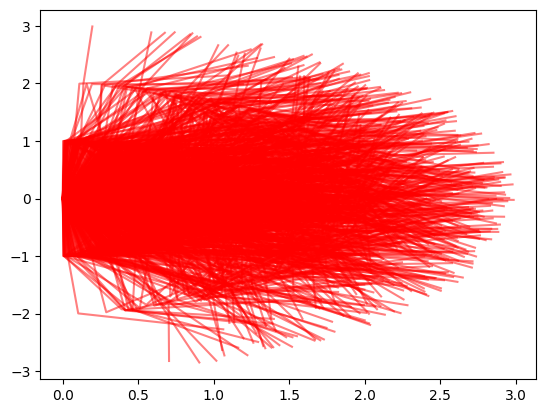

In [24]:
arm_pos = calc_arm_pos(x)
for i in range(arm_pos.shape[0]):
    plt.plot(
        arm_pos[i, :, 0],
        arm_pos[i, :, 1],
        label="Original Data",
        c="red",
        alpha=0.5,
    )

In [25]:
col_red = '#c61826'
col_dark_red = '#590d08'
col_blue = '#01024d'

Percentage of points inside the area: 0.91
Percentage of points outside the area: 0.09


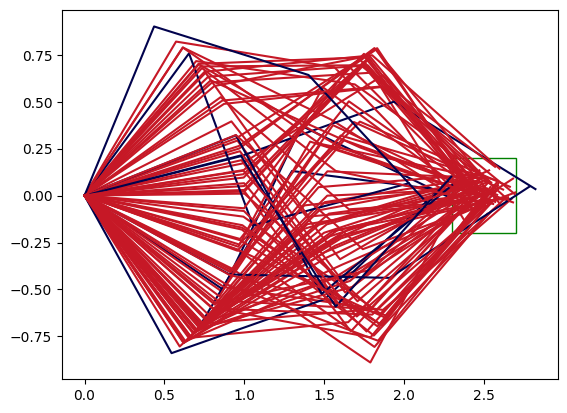

In [35]:
n = 100
x_ = 2.5
y_ = 0.0
in_counter = 0
out_counter = 0
tol_area = 0.2
node = NeuralODE(
            torch_wrapper(model),
            solver="dopri5",
            sensitivity="adjoint",
            atol=1e-4,
            rtol=1e-4,
        )
with torch.no_grad():
        x0 = (
        torch.tensor(
        np.random.normal([0] * num_dims, 1, size=(n, num_dims))
        )
        .to(device)
        .float()
        )
        x0 = torch.cat([x0, torch.tensor([[x_, y_]]*n)], dim=-1).float()
        traj = node.trajectory(
        x0,
        t_span=torch.linspace(0, 1, 100),
        )
        result = traj[-1, :, :3]
plt.figure()
arm_pos = calc_arm_pos(result).cpu().detach().numpy()

for i in range(len(arm_pos)):
    if (
        arm_pos[i, -1, 0] > x_ + tol_area
        or arm_pos[i, -1, 0] < x_ - tol_area
        or arm_pos[i, -1, 1] > y_ + tol_area
        or arm_pos[i, -1, 1] < y_ - tol_area
    ):
        out_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_blue,
            alpha=1,
        )
    else:
        in_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_red,
            alpha=1,
        )
rec = patches.Rectangle((x_ - tol_area, y_ - tol_area), 2*tol_area, 2*tol_area, linewidth=1, edgecolor='green', facecolor='none')
plt.gca().add_patch(rec)

print(f"Percentage of points inside the area: {in_counter / n}")
print(f"Percentage of points outside the area: {out_counter / n}")

In [27]:
y = calc_y(result).detach().numpy()

In [28]:
print(np.mean(y[:, 0]), np.mean(y[:, 1]))

2.5018778 0.03000091


In [29]:
print(np.cov(y[:, 0], y[:, 1]))

[[0.01848675 0.00022196]
 [0.00022196 0.00596006]]


In [30]:
target = [x_, y_]

In [31]:
print(np.mean(np.sqrt((y[:, 0] - target[0])**2 + (y[:, 1] - target[1])**2)))

0.13466667


In [32]:
print(np.min(np.sqrt((y[:, 0] - target[0])**2 + (y[:, 1] - target[1])**2)))

0.00086336036


In [33]:
print(np.max(np.sqrt((y[:, 0] - target[0])**2 + (y[:, 1] - target[1])**2)))

0.4172352


Percentage of points inside the area: 0.91
Percentage of points outside the area: 0.09


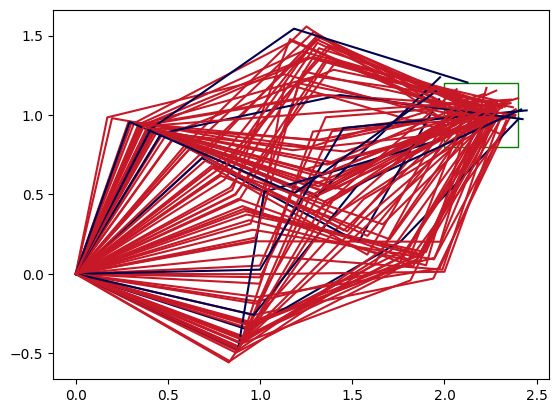

In [36]:
n = 100
x_ = 2.2
y_ = 1.0
in_counter = 0
out_counter = 0
tol_area = 0.2
node = NeuralODE(
            torch_wrapper(model),
            solver="dopri5",
            sensitivity="adjoint",
            atol=1e-4,
            rtol=1e-4,
        )
with torch.no_grad():
        x0 = (
        torch.tensor(
        np.random.normal([0] * num_dims, 1, size=(n, num_dims))
        )
        .to(device)
        .float()
        )
        x0 = torch.cat([x0, torch.tensor([[x_, y_]]*n)], dim=-1).float()
        traj = node.trajectory(
        x0,
        t_span=torch.linspace(0, 1, 100),
        )
        result = traj[-1, :, :3]
plt.figure()
arm_pos = calc_arm_pos(result).cpu().detach().numpy()

for i in range(len(arm_pos)):
    if (
        arm_pos[i, -1, 0] > x_ + tol_area
        or arm_pos[i, -1, 0] < x_ - tol_area
        or arm_pos[i, -1, 1] > y_ + tol_area
        or arm_pos[i, -1, 1] < y_ - tol_area
    ):
        out_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_blue,
            alpha=1,
        )
    else:
        in_counter += 1
        plt.plot(
            arm_pos[i, :, 0],
            arm_pos[i, :, 1],
            label="Original Data",
            c=col_red,
            alpha=1,
        )
rec = patches.Rectangle((x_ - tol_area, y_ - tol_area), 2*tol_area, 2*tol_area, linewidth=1, edgecolor='green', facecolor='none')
plt.gca().add_patch(rec)

print(f"Percentage of points inside the area: {in_counter / n}")
print(f"Percentage of points outside the area: {out_counter / n}")